<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [7.1 Introduction to Simpy](https://jckantor.github.io/cbe30338-2021/07.01-Introduction-to-Simpy.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.3 Chemotaxis](https://jckantor.github.io/cbe30338-2021/07.03-Chemotaxis.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/07.02-Agent-Based-Models.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/07.02-Agent-Based-Models.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 7.2 Agent Based Models

In [1]:
!pip install simpy

## 7.2.1 Simpy: What we have learned so far

* Simpy provides a simulation environment for discrete-event simulation
* Python generators model "agents" in a larger system.

What we will learn in this unit:

* Modeling multiple units
* Modeling a shared resource
* Extracting data from a data log

## 7.2.2 3.3.2 Example: A room full of Roombas

Let's imagine a large facility that is being cleaned by a collection of Roomba-type robotic cleaning units.  Each unit is characterized by time required to charge, and an amount of time it can clean before needing to be recharged. The facility must be cleaned during a 16 hour overnight shift. On average, 3 units must be operating continuously to meet the cleaning requirements, i.e., 3 x 16 = 48 hours machine cleaning each night. We would like to determine how many charging stations will be required.

| Unit | Charge Time (hrs) | Clean Time (hrs) |
| :--: | :--: | :--: |
| A | 1.0 | 2.5 |
| B | 0.5 | 1.5 |
| C | 0.8 | 2.0 |
| D | 1.4 | 3.5 |
| E | 0.5 | 1.2 |
| F | 1.0 | 3.0 |

![roomba](https://upload.wikimedia.org/wikipedia/commons/2/27/%D0%A0%D0%BE%D0%B1%D0%BE%D1%82_%D0%BF%D1%8B%D0%BB%D0%B5%D1%81%D0%BE%D1%81_Roomba_780.jpg)

In [35]:
import pandas as pd

roomba_data = [
    ["A", 1.0, 2.5],
    ["B", 0.5, 1.5],
    ["C", 0.8, 2.0],
    ["D", 1.4, 3.5],
    ["E", 0.5, 1.2],
    ["F", 1.0, 3.0],
]

roomba_df = pd.DataFrame(roomba_data, columns=["id", "charge_time", "clean_time"])
roomba_df

id  charge_time  clean_time
0  A          1.0         2.5
1  B          0.5         1.5
2  C          0.8         2.0
3  D          1.4         3.5
4  E          0.5         1.2
5  F          1.0         3.0

## 7.2.3 One Roomba

The first challenge is to model the performance of a single Roomba. Our first attempt at a model consists of a simple Python generator. The data log consists of start and finish of each charge and cleaning cycle. For this first attempt, we'll assume a charging station is always available when needed, and we'll create just one instance of a Roomba to get started.

In [36]:
import simpy 
import pandas as pd

# create an empty data log
data_log = []

# The Roomba model isa Python generator. The id, charge_time, and clean_time
# parameters are the information needed to specify a particular instance of a Roomba.
# The model will log the begin and end of each charge and clean cycle.

def roomba(id, charge_time, clean_time):
    while True:
        # cleaning phase
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
   
        # charging phase
        tic = env.now
        yield env.timeout(charge_time)
        toc = env.now
        data_log.append([id, "charging", tic, toc])

# create the simulation environment
env = simpy.Environment()

# create the processes being simuulated
env.process(roomba("A", 1.0, 2.5))

# run the simulation
env.run(until=16)

print(data_log)

[['A', 'cleaning', 0, 2.5], ['A', 'charging', 2.5, 3.5], ['A', 'cleaning', 3.5, 6.0], ['A', 'charging', 6.0, 7.0], ['A', 'cleaning', 7.0, 9.5], ['A', 'charging', 9.5, 10.5], ['A', 'cleaning', 10.5, 13.0], ['A', 'charging', 13.0, 14.0]]


## 7.2.4 Processing the data log with Pandas

### 7.2.4.1 Convert nested list to a Pandas Dataframe

In [37]:
df = pd.DataFrame(data_log, columns=["id", "activity", "begin", "end"])
df["time"] = df["end"] - df["begin"]
display(df)

id  activity  begin   end  time
0  A  cleaning    0.0   2.5   2.5
1  A  charging    2.5   3.5   1.0
2  A  cleaning    3.5   6.0   2.5
3  A  charging    6.0   7.0   1.0
4  A  cleaning    7.0   9.5   2.5
5  A  charging    9.5  10.5   1.0
6  A  cleaning   10.5  13.0   2.5
7  A  charging   13.0  14.0   1.0

### 7.2.4.2 Aggregating data with pivot tables

Among the many great reasons to use a Pandas dataframe for manipulating data are pivot tables. Pivot tables aggregate data using labels that appear in selected columns. In this case, we seek to aggregate data using labels appearing in the "id" and "activity" columns. The type of aggregation is to sum entries appearing in the "time".

In [38]:
pd.pivot_table(df, index=["activity"], aggfunc={"time":sum} )

time
activity      
charging   4.0
cleaning  10.0

## 7.2.5 Adding the full complement of Roombas

The next step is to include all of the available Roombas to the simulation. We do this by looping over the data set that describes the available devices. For each interation, an instance of the Roomba model is created and an associated process added to the simulation environment.

In [39]:
import simpy 
import pandas as pd

# create an empty data log
data_log = []

# The Roomba model isa Python generator. The id, charge_time, and clean_time
# parameters are the information needed to specify a particular instance of a Roomba.
# The model will log the begin and end of each charge and clean cycle.

def roomba(id, charge_time, clean_time):
    while True:
        # cleaning phase
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
   
        # charging phase
        tic = env.now
        yield env.timeout(charge_time)
        toc = env.now
        data_log.append([id, "charging", tic, toc])

# create the simulation environment
env = simpy.Environment()

for r in roomba_df.index:
    env.process(roomba(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))

# run the simulation
env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "activity", "begin", "end"])
df["time"] = df["end"] - df["begin"]
display(df)

id  activity  begin   end  time
0   E  cleaning    0.0   1.2   1.2
1   B  cleaning    0.0   1.5   1.5
2   E  charging    1.2   1.7   0.5
3   C  cleaning    0.0   2.0   2.0
4   B  charging    1.5   2.0   0.5
.. ..       ...    ...   ...   ...
59  D  charging   13.3  14.7   1.4
60  E  cleaning   13.6  14.8   1.2
61  F  cleaning   12.0  15.0   3.0
62  E  charging   14.8  15.3   0.5
63  B  cleaning   14.0  15.5   1.5

[64 rows x 5 columns]

In [40]:
df["time"] = df["end"] - df["begin"]
pd.pivot_table(df, index=["activity"], aggfunc={"time":sum} )

time
activity      
charging  23.2
cleaning  65.3

<hr>

**Study Question:** Change the pivot table to report total time spent charging and cleaning. The warehouse requires 48 hours of cleaning time. Is this requirement satisfied?

**Study Question:** Demonstrate that the warehouse requirements can be met by one less Roomba.

<hr>

### 7.2.5.1 Gantt Charts

Create a function that accepts df (the data log after converting to a pandas DataFrame) and, for every Roomba, shows a time line of events.

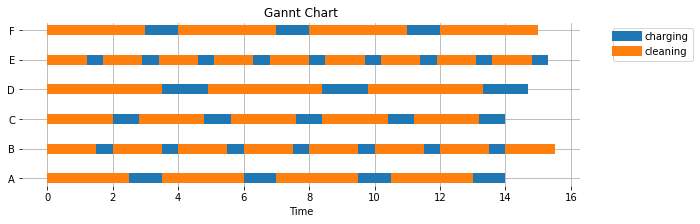

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def gantt(df, lw=10):
    
    # create sorted lists of the unique ids and activities appearing in the data log
    ids = sorted(list(set(df["id"])))
    activities = sorted(list(set(df["activity"])))
    
    # create list of unique colors for each event
    colors = [f"C{i}" for i in range(len(activities))]
    
    # create plot window
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    
    # for each event and id, find entries in the data log and plot the begin and end points
    for i, activity in enumerate(activities):
        for j, id in enumerate(ids):  
            for k in df[(df["id"]==id) & (df["activity"]==activity)].index:
                ax.plot([df["begin"][k], df["end"][k]], [j, j], colors[i], solid_capstyle="butt", lw=lw)
                
    # create legend
    lines = [Line2D([0], [0], lw=lw, color=colors[i]) for i in range(len(activities))]
    ax.legend(lines, activities, bbox_to_anchor=(1.05, 1.0), loc="upper left")
    
    # annotate the axes
    ax.set_yticks(range(len(ids)))
    ax.set_yticklabels(ids)
    ax.grid(True)
    ax.set_xlabel("Time")
    ax.set_title("Gannt Chart")
    for sp in ['top', 'bottom', 'right', 'left']:
        ax.spines[sp].set_visible(False)
        
gantt(df)

## 7.2.6 Charging stations as shared resources

A charging station is an example of a **shared resource**. There are three types of resources that can be modeled in Simpy:

* **Resource** Resources that can only used by a limited number of processes at a time.
* **Stores** Resources that can store or release Python objects.
* **Containers** Resources that model the production and consumption of bulk goods.

In this example, charging stations are an example of `Resources`. 

The next cell shows how a charging station can be incorporated into the simulation as a shared resource. Three changes required:

* Create a simpy.Resource() by specifying the simulation environment and resource capacity. 
* The Roomba model must create request for use of a charger. The request is specified in a subsequent `yield` statement. Execution resumes once a charger becomes available.
* When finished with a charger, the model must release the charger so that it is available for use in other model instances.

The following cell implements charger system with a capacity of 1. Examine the data log to verify that only one Roomba is charging at any point in time.

          time
activity      
charging  14.7
cleaning  43.5


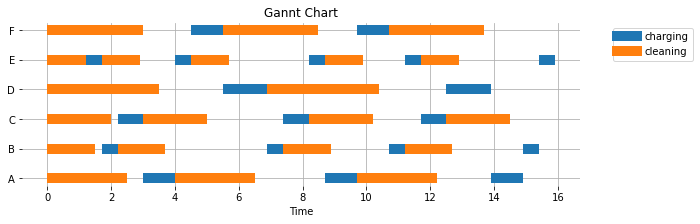

In [34]:
import simpy 
import pandas as pd

data_log = []

def roomba_model(id, charge_time, clean_time):
    while True:
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
        
        request = chargers.request()
        yield request
        tic = env.now
        yield env.timeout(charge_time)
        chargers.release(request)
        toc = env.now
        data_log.append([id, "charging", tic, toc])
   
env = simpy.Environment()
chargers = simpy.Resource(env, capacity=1)

for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))

env.run(until=16)

df = pd.DataFrame(data_log, columns=["id", "activity", "begin", "end"])
df["time"] = df["end"] - df["begin"]
pivot_table = pd.pivot_table(df, index=["activity"], aggfunc={"time":sum} )

print(pivot_table)
gantt(df)

## 7.2.7 How many charging stations are required?

The following cell uses the Python `with` statement to request a changer and release it upon completion of a code block. The advantage of this construction is that it handles the release automatically, thereby avoiding a potential source of coding errors, and also provides a visual demarcation of the code block where the charger is being use.

The cell also uses the Pandas `pivot_table` to report the total amount of charging used and cleaning time provided. Find the minimum number of chargers required to produce 48 hours of cleaning time in a 16 hour shift.

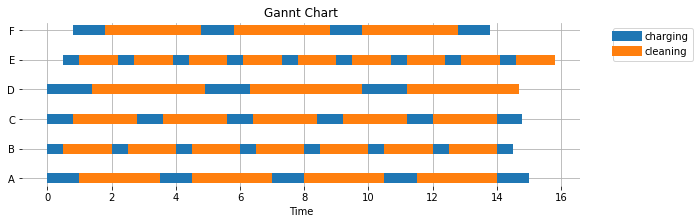

In [25]:
import simpy 
import pandas as pd
import numpy as np

data_log = []

def roomba_model(id, charge_time, clean_time):
    while True:
        with chargers.request() as request:
            yield request
            tic = env.now
            yield env.timeout(charge_time)
            toc = env.now
            data_log.append([id, "charging", tic, toc])
            
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
        
env = simpy.Environment()
chargers = simpy.Resource(env, capacity=4)

for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))

env.run(until=16)
df = pd.DataFrame(data_log, columns=["id", "activity", "begin", "end"])

df["time"] = df["end"] - df["begin"]
pd.pivot_table(df, index=["activity"], aggfunc={"time":sum} )

gantt(df)

---

**Study Question:** Rerun the simulation to determine the minimum number of chargers required to meet the requirement for 48 hours of cleaning in a 16 hour shift.

**Study Question:** Modify the model to assume the changers are not charged at the start of the cleaning shift. Does that change the number of chargers required to meet the cleaning requirement?

**Study Question:** Assume each Roomba needs to dispose of waste after 20 minutes of cleaning, that it takes 5 minutes to dispose of the waste, and requires access to a waste disposal station. 

Hints:
* You will need to create a log a new event called 'waste disposal'. 
* Model the waste disposal station as a shared resource.
* You may need to make some decisions on how to handle the waste at the end of a cleaning cycle.


---

## 7.2.8 Adding a reporter process

          time
activity      
charging  22.7
cleaning  62.6


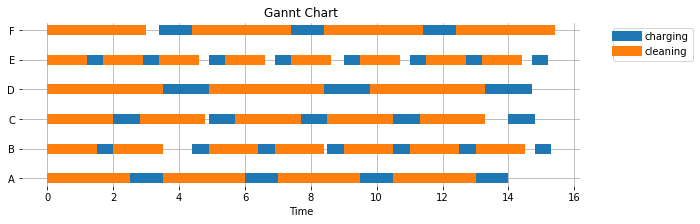

In [61]:
import simpy 
import pandas as pd
import numpy as np

data_log = []

def roomba_model(id, charge_time, clean_time):
    while True:
        tic = env.now
        yield env.timeout(clean_time)
        toc = env.now
        data_log.append([id, "cleaning", tic, toc])
        
        with chargers.request() as request:
            yield request
            tic = env.now
            yield env.timeout(charge_time)
            toc = env.now
            data_log.append([id, "charging", tic, toc])
            
reporter_log = []
def reporter(dt):
    while True:
        reporter_log.append([env.now, chargers.count])
        yield env.timeout(dt)
        
env = simpy.Environment()
chargers = simpy.Resource(env, capacity=2)

for r in roomba_df.index:
    env.process(roomba_model(roomba_df["id"][r], roomba_df["charge_time"][r], roomba_df["clean_time"][r]))
    
env.process(reporter(0.1))

env.run(until=16)
df = pd.DataFrame(data_log, columns=["id", "activity", "begin", "end"])

df["time"] = df["end"] - df["begin"]
print(pd.pivot_table(df, index=["activity"], aggfunc={"time":sum}))

gantt(df)

(array([17.,  0.,  0., 54.,  0., 90.]),
 array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        ]),
 <BarContainer object of 6 artists>)

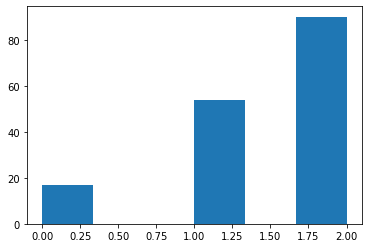

In [62]:
data = np.array(reporter_log)
plt.hist(data[:,1], 6)

<!--NAVIGATION-->
< [7.1 Introduction to Simpy](https://jckantor.github.io/cbe30338-2021/07.01-Introduction-to-Simpy.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.3 Chemotaxis](https://jckantor.github.io/cbe30338-2021/07.03-Chemotaxis.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/07.02-Agent-Based-Models.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/07.02-Agent-Based-Models.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>